<a href="https://colab.research.google.com/github/saxenabhishek/DL-project/blob/main/tf_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! wget https://s3.amazonaws.com/google-landmark/train/images_001.tar
! wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
! tar -xf images.tar.gz

--2022-04-29 05:27:22--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   111MB/s    in 6.9s    

2022-04-29 05:27:29 (110 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!mkdir parent_dir

In [ ]:
!mv /content/images /content/parent_dir/images

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8707178367034739842
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13246691566582104868
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
from PIL import Image, ImageCms
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from skimage import io, color

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
size = (256, 256)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/parent_dir/",
  validation_split=0.2,
  subset="training",
  seed=102,
  batch_size=8)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/parent_dir/",
  validation_split=0.2,
  subset="validation",
  seed=102,
  batch_size=8)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 7390 files belonging to 1 classes.
Using 5912 files for training.
Found 7390 files belonging to 1 classes.
Using 1478 files for validation.


In [ ]:
def preProc(A,y):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    C = normalization_layer(A)
    B = tf.keras.preprocessing.image.smart_resize(C, size)
    A = tf.image.rgb_to_hsv(B)
    return A[:,:,:,-1:], A[:,:,:,:-1]

Pro_train_ds = train_ds.map(preProc)
Pro_val_ds = val_ds.map(preProc)

Pro_train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [ ]:
it = iter(Pro_val_ds)

In [ ]:
def combine_image(i1,i2):
    return tf.image.hsv_to_rgb(np.concatenate((i1,i2),axis = 2))

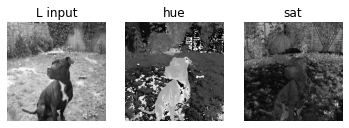

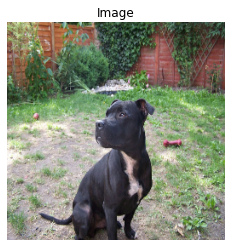

In [ ]:
A = next(it)
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
ax[0].imshow(A[0][5][:,:,0],cmap="gray")
ax[1].imshow(A[1][5][:,:,0],cmap="gray")
ax[2].imshow(A[1][5][:,:,1],cmap="gray")
ax[0].title.set_text("L input");ax[1].title.set_text("hue");ax[2].title.set_text("sat")
    
ax[0].axis(False);ax[1].axis(False);ax[2].axis(False);
plt.show()

plt.imshow(combine_image(A[1][5],A[0][5]))
plt.title("Image")
plt.axis(False)
plt.show()


In [ ]:
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers


ALP = 0.2

inputs = tf.keras.Input(shape=(256, 256,1))

x = layers.LeakyReLU(alpha=ALP)(inputs)
for i in [8, 16, 32, 64]:
    x = layers.Conv2D(i, 3,padding="same",
                kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-2),
                activity_regularizer=regularizers.L2(0.01)
                )(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.MaxPool2D()(x)

# x = layers.Dense(32,
#                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 activity_regularizer=regularizers.L2(0.01)
#                  )(x) 
# x = layers.LeakyReLU(alpha=ALP)(x)


for i in [8, 16, 32, 64][::-1]:
    x = layers.Conv2D(i, 5,padding = "same",
                    kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-2),
                    activity_regularizer=regularizers.L2(0.01)
                    )(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

x = layers.Add()([x,inputs])

x = layers.Conv2D(2, 3,padding = "same",activation="sigmoid")(x)


In [ ]:
model = tf.keras.Model(inputs, x)

print(model.summary())

model.compile(optimizer="rmsprop",  loss="MSE")

%time H = model.fit(Pro_train_ds, epochs=5, verbose=1, validation_data=Pro_val_ds)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['leaky_re_lu[0][0]']            
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 256, 256, 8)  0           ['conv2d[0][0]']           

In [ ]:
%time H = model.fit(Pro_train_ds, epochs=15, verbose=1, validation_data=Pro_val_ds)

Epoch 1/15
739/739 [==============================] - 55s 74ms/step - loss: 1.0813 - val_loss: 1.0761
Epoch 2/15
739/739 [==============================] - 55s 74ms/step - loss: 1.0799 - val_loss: 1.0790
Epoch 3/15
739/739 [==============================] - 55s 74ms/step - loss: 1.0798 - val_loss: 1.0792
Epoch 4/15
739/739 [==============================] - 54s 74ms/step - loss: 1.0797 - val_loss: 1.0786
Epoch 5/15
739/739 [==============================] - 54s 73ms/step - loss: 1.0797 - val_loss: 1.0793
Epoch 6/15
739/739 [==============================] - 57s 77ms/step - loss: 1.0797 - val_loss: 1.0795
Epoch 7/15
739/739 [==============================] - 57s 78ms/step - loss: 1.0797 - val_loss: 1.0796
Epoch 8/15
739/739 [==============================] - 55s 74ms/step - loss: 1.0797 - val_loss: 1.0792
Epoch 9/15
739/739 [==============================] - 58s 78ms/step - loss: 1.0797 - val_loss: 1.0791
Epoch 10/15
739/739 [==============================] - 58s 78ms/step - loss: 1.079

In [ ]:
%time H = model.fit(Pro_train_ds, epochs=10, verbose=1, validation_data=Pro_val_ds)

Epoch 1/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0618
Epoch 2/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0624
Epoch 3/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 4/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 5/10
739/739 [==============================] - 36s 48ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 6/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0618
Epoch 7/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 8/10
739/739 [==============================] - 36s 49ms/step - loss: 0.0621 - val_loss: 0.0617
Epoch 9/10
739/739 [==============================] - 36s 48ms/step - loss: 0.0621 - val_loss: 0.0617
Epoch 10/10
739/739 [==============================] - 36s 49ms/step - loss: 0.062

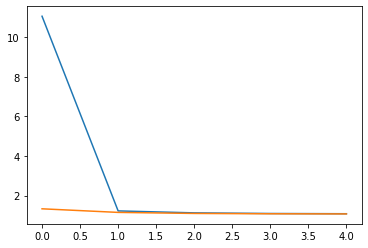

In [ ]:
plt.plot(H.history["loss"])
plt.plot(H.history["val_loss"])

In [ ]:
it = iter(Pro_val_ds)

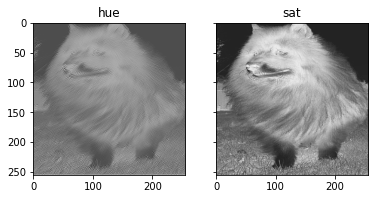

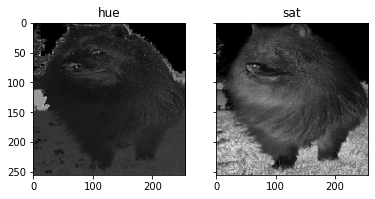

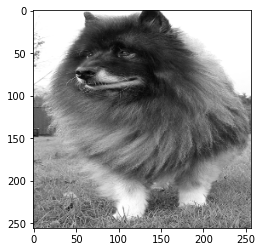

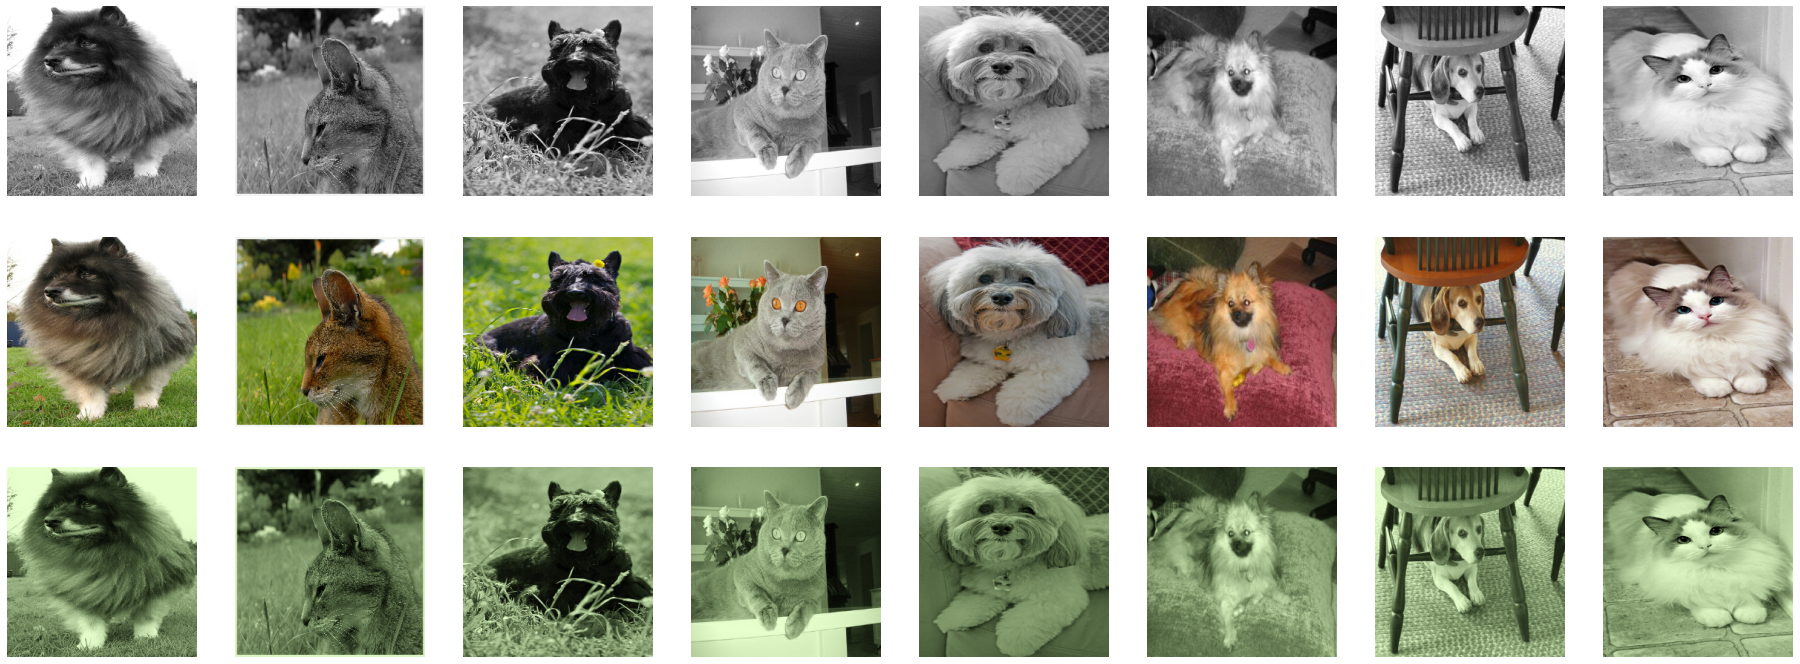

<Figure size 432x288 with 0 Axes>

In [ ]:
sample = next(it)
#P = next(iter)(Pro_val_ds))

pred = model.predict(sample[0])

A = pred[0]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(A[:,:,0],cmap="gray")
ax[1].imshow(A[:,:,1],cmap="gray")
ax[0].title.set_text("hue");ax[1].title.set_text("sat")
plt.show()

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(sample[1][0][:,:,0],cmap="gray")
ax[1].imshow(sample[1][0][:,:,1],cmap="gray")
ax[0].title.set_text("hue");ax[1].title.set_text("sat")
plt.show()

plt.imshow(sample[0][0][:,:,0],cmap="gray")
plt.show()

fig,ax = plt.subplots(3, 8, sharex=True, sharey=True, figsize = (8*4, 3*4))
plt.figure()

for i in range(8):
    
    ax[0,i].imshow(sample[0][i][:,:,0],cmap = "gray")
    ax[1,i].imshow(combine_image(sample[1][i],sample[0][i]))
    ax[2,i].imshow(combine_image(pred[i],sample[0][i]))
    ax[0,i].axis(False);ax[1,i].axis(False);ax[2,i].axis(False)   


In [ ]:
model.save("Recolor")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Recolor/assets


In [ ]:
!zip -r /content/Recolor.zip /content/Recolor/

  adding: content/Recolor/ (stored 0%)
  adding: content/Recolor/saved_model.pb (deflated 91%)
  adding: content/Recolor/assets/ (stored 0%)
  adding: content/Recolor/variables/ (stored 0%)
  adding: content/Recolor/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/Recolor/variables/variables.index (deflated 71%)
